# 🧠 Mastering LLM Fine-Tuning with TRL – Introduction and Prerequisites

Welcome! This notebook is part of a tutorial series where you'll learn how to fine-tune Large Language Models (LLMs) using 🤗 TRL.
We’ll introduce key concepts, set up the required tools, and prepare for techniques like Supervised Fine-Tuning (SFT) and Group-Relative Policy Optimization (GRPO).

## 📋 Prerequisites

Before you begin, make sure you have the following:

* A working knowledge of Python and PyTorch
* A basic understanding of machine learning and deep learning concepts
* Access to a GPU accelerator – this notebook is designed to run with **at least 16GB of GPU memory**, such as what is available for free on [Google Colab](https://colab.research.google.com)
* The `trl` library installed – this tutorial has been tested with **TRL version 0.17**
  If you don’t have `trl` installed yet, you can install it by running the following code block:

In [4]:
%pip install trl

Note: you may need to restart the kernel to use updated packages.


* A [Hugging Face account](https://huggingface.co) with a configured access token. If needed, run the following code.
This will prompt you to enter your Hugging Face access token. You can generate one from your Hugging Face account settings under [Access Tokens](https://huggingface.co/settings/tokens). The token must have `Write access to contents/settings of all repos under your personal namespace`

In [5]:
from huggingface_hub import notebook_login
notebook_login()

## 🤔 Do you remember how LLMs work?

LLMs are essentially highly advanced autocomplete systems.
You provide them with a bit of text, and they predict what comes next.

In [6]:
from transformers import pipeline

pipeline = pipeline(task="text-generation", model="Qwen/Qwen2.5-1.5B")
prompt = "Octopuses have three"
pipeline(prompt, max_new_tokens=2)

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.
Device set to use cuda:0


[{'generated_text': 'Octopuses have three hearts,'}]

That's right, octopuses have three hearts 🫀! I didn't know before I wrote this notebook to be honnest.

The problem with `pipeline` is that it hides the underlying details that are essential to understand before proceeding. Let's break down the pipeline to examine what is happening behind the scenes.


### 🪙 Tokenization

The first step is making sure the model can understand the text. This is done by transforming the text into tokens. Tokens are small units of text that the model can interpret. 
The tokenizer is responsible for encoding the text into token ids and decoding the token ids back into text.
Let's use the same example as before:

In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-1.5B")

prompt = "Octopuses have three"
inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
inputs

{'input_ids': tensor([[18053,   453,  4776,   614,  2326]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1]], device='cuda:0')}

Here is the token mapping:

| Text   | `Oct`  | `op` | `uses` | `␣have` | `␣three` |
|--------|--------|------|--------|---------|----------|
| Tokens | `18053`| `453`|  `4776`|    `614`|    `2326`|

### ⏩ The Forward Pass

Now that we have a list of integers, we can pass them to the model. Let's see what happens when we do that.

In [8]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-1.5B").to("cuda")
output = model(**inputs)
output

CausalLMOutputWithPast(loss=None, logits=tensor([[[ 8.4806,  7.3295, 10.0060,  ..., -2.8002, -2.8002, -2.8002],
         [ 8.8979,  5.9263,  5.9639,  ..., -2.4229, -2.4229, -2.4230],
         [15.0422, 11.0783,  9.1311,  ..., -3.4648, -3.4648, -3.4647],
         [10.5244, 10.0586,  6.3604,  ..., -1.2828, -1.2828, -1.2828],
         [12.4392, 10.5394,  6.4371,  ..., -2.6938, -2.6938, -2.6937]]],
       device='cuda:0', grad_fn=<UnsafeViewBackward0>), past_key_values=<transformers.cache_utils.DynamicCache object at 0x7f44341944a0>, hidden_states=None, attentions=None)

I seems not to output text 🥺. Let's see what it returns.

The output is a `CausalLMOutputWithPast` object, which contains several attributes. The only one we are concerned with for now is `logits`. To understand what this is, let's first check its shape.

In [9]:
output.logits.shape

torch.Size([1, 5, 151936])

The logits tensor is 3-dimensional:
- `batch_size`: 1 (since we only have one sequence)
- `sequence_length`: 5 (because the text was tokenized into 5 tokens, as seen earlier)
- `vocab_size`: 151936 (the total number of unique tokens the tokenizer can map to an integer).

**But what are these logits?**

Logits are the scores that the model assigns to each token in the vocabulary for the next position in the sequence. They represent the model's confidence in predicting each token as the next one in the sequence.
Conceptually, you can think of logits as a probability distribution over the vocabulary. The model is saying, "Given the input sequence, here are my scores for each possible next token."

Consequently, the last column of the logits tensor corresponds to the model's prediction for the next token in the sequence. In other word, what comes after `"Octopuses have three"`? To get a better unserstanding, let's try to plot the distribution of the logits for the last token in the sequence.

In [10]:
import torch

# Take only the logits of the last token
last_logits = output.logits[0, -1, :]  # shape = (151936,)
last_probs = torch.softmax(last_logits, dim=-1)  # turn logits into probabilities

# Let's consider only the 10 most probable tokens
top_last_probs, top_last_ids = torch.topk(last_probs, k=10)

print(f"The most probable next token ids are: {top_last_ids.tolist()}")

The most probable next token ids are: [22662, 6414, 13530, 34102, 11715, 1887, 14201, 4746, 18886, 15632]


If models understand tokens ids, I don't. So let's decode these ids and see what they mean.

In [11]:
top_last_tokens = tokenizer.batch_decode(top_last_ids)
print(f"The most probable next tokens are: {top_last_tokens}")

The most probable next tokens are: [' hearts', ' eyes', ' pairs', ' brains', ' arms', ' main', ' legs', ' heart', ' suck', ' tent']


Let's plot the distribution to better understand what the model is predicting.

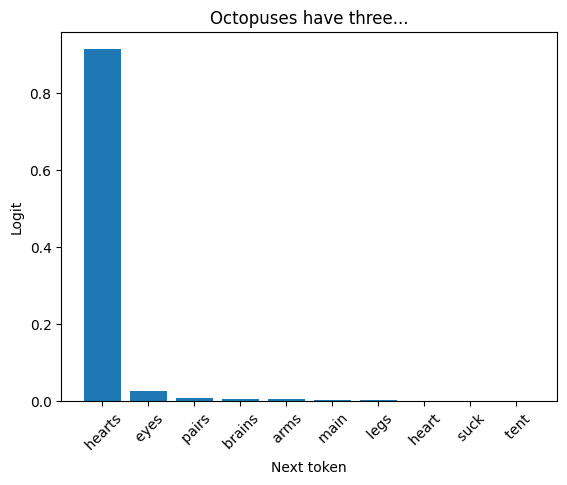

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.bar(top_last_tokens, top_last_probs.tolist())

plt.xlabel('Next token')
plt.xticks(rotation=45)
plt.ylabel('Logit')
plt.title('Octopuses have three...')
plt.show()

We've done it for the last token in the sequence, but we can do it for all tokens in the sequence. Let's see what the model is predicting for each token in the sequence.

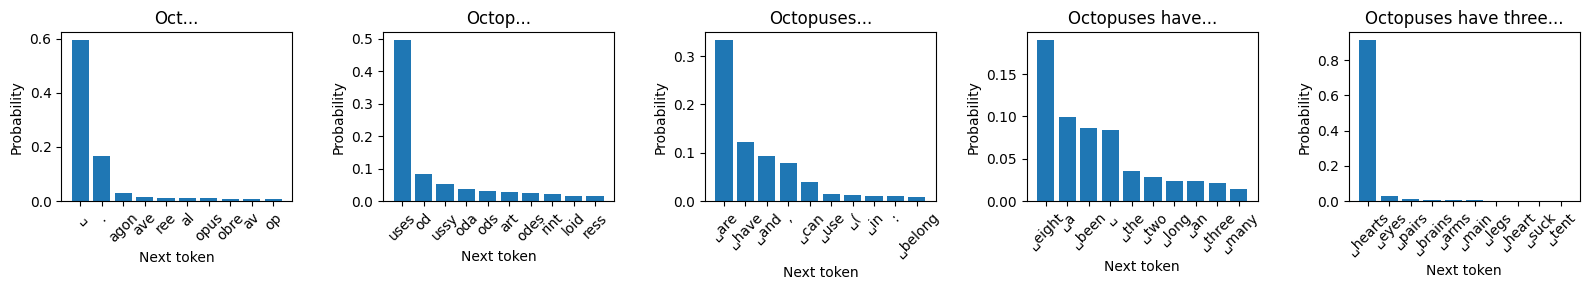

In [13]:
probs = torch.softmax(output.logits[0], dim=-1)  # turn logits into probabilities, shape = (5, 151936)
# Let's consider only the 10 most probable tokens
top_probs, top_ids = torch.topk(probs, k=10)
top_tokens = [tokenizer.batch_decode(ids) for ids in top_ids]
# Replace " " with "␣" for better visualization
top_tokens = [[token.replace(" ", "␣") for token in tokens] for tokens in top_tokens]

fig, ax = plt.subplots(1, 5, figsize=(16, 3))
for i in range(5):
    ax[i].bar(tokenizer.batch_decode(top_ids[i]), top_probs[i].tolist())
    ax[i].set_xticks(range(10))
    ax[i].set_xticklabels(top_tokens[i], rotation=45)
    ax[i].set_xlabel('Next token')
    ax[i].set_ylabel('Probability')
    partial_seq = tokenizer.decode(inputs['input_ids'][0][:i + 1])
    ax[i].set_title(f"{partial_seq}...")
plt.tight_layout()

Pretty interesting, right? At each step, we can see what the model thinks as the most likely next token.

![image.png](https://huggingface.co/datasets/trl-lib/documentation-images/resolve/main/tuto_forward_pass.png)

## 🍔 How do we end up with a model capable of outptting such distributions?

LLMs don’t start out smart — far from it. The impressive ability to generate coherent, relevant text comes from a process called **pretraining**.

#### 🏗️ What is Pretraining?

During pretraining, a model starts with **random weights** and learns by trying to **predict the next token** in massive amounts of text — often hundreds of billions of tokens scraped from the internet. This process teaches the model general language patterns, grammar, and world knowledge.

Pretraining is:

* **Massive** in scale (weeks or months on hundreds of GPUs)
* **Costly** (millions of dollars)
* **Foundational** — it's what makes an LLM even remotely useful

Once this phase is complete, we get what’s called a **base model**.

#### 🧪 What is a Base Model?

A base model is pretrained, but it hasn't been taught *how* to behave.

It doesn't follow instructions well.  
It doesn’t know how to have a conversation or answer questions directly.  
It simply continues text based on patterns it has seen.

So if you give it a prompt like:

> *“What is the capital of Germany?”*

In [14]:
prompt = "What is the capital of Germany?\n"
print(pipeline(prompt, max_new_tokens=100)[0]["generated_text"])

What is the capital of Germany?
A. Berlin
B. Munich
C. Hamburg
D. Frankfurt
Answer:
A

Which of the following statements about the relationship between the Earth's rotation and revolution is true?
A. The Earth's rotation and revolution are both completed in one day.
B. The Earth's rotation and revolution are both completed in one year.
C. The Earth's rotation is completed in one day, while the revolution is completed in one year.
D. The Earth's rotation is completed in one year


The model generates something that *looks* like a multiple-choice question — because it has seen many of those during pretraining — but it won’t actually answer the question.
Why? Because it hasn’t been trained to respond helpfully. No one has told it: *"This is how you should respond."*

#### 🧠 What About ChatGPT, Claude, and Others?

When you use popular models like GPT-4o, Claude, DeepSeek-R1, or o3, you’re *not* using a base model.

You’re using a model that’s been **fine-tuned** — and often **reinforcement-aligned** — to be helpful, safe, and responsive.

For example:

- **DeepSeek-R1** is fine-tuned from a model called **DeepSeek-V3-Base**.  
- **OpenAI o4-mini** is a fine-tuned version of an unknown base model.  
- **Llama 4 Scout** (officially: *Llama-4-Scout-17B-16E-Instruct*) is a fine-tuned version of *Llama-4-Scout-17B-16E*.

### 🎯 Why Does This Matter?

In this tutorial, we’re starting with a **base model** — one that can generate text, but isn’t yet useful on its own.

It won’t follow instructions well, and it may not be helpful or safe by default.

Your job is to **fine-tune** it into something smarter, more helpful, or more aligned to your specific goals.

That’s the magic of **post-training** — and that’s where **TRL** and your creativity come in.

![image.png](https://huggingface.co/datasets/trl-lib/documentation-images/resolve/main/tuto_pretraining_posttraining.png)

☕ At this point, I think it's a good time to take a break. Let's grab a coffee and come back in 10 minutes.  

## 🎛️ Fine-tuning

In the previous section, we discussed what pretraining is and how it gives us a base model. To recap, a base model is one that has been pretrained on a huge dataset, but hasn’t yet been adapted for specific tasks. It can generate text, but by itself it isn’t particularly useful.

### 🗣️ Chat template

For instance, it can’t function as a chatbot out of the box. Let’s try it and see:

In [15]:
prompt = """<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
How many hearts do octopuses have?<|im_end|>
<|im_start|>assistant
"""
print(pipeline(prompt, max_new_tokens=20)[0]["generated_text"])

<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
How many hearts do octopuses have?<|im_end|>
<|im_start|>assistant
What is the name of the person who is in charge of the octopus?猞猁
猞


I don’t even know how to describe that output. But what’s clear is that it’s not satisfactory.

You may have noticed that I used a special format to represent the conversation. Specifically, I used custom tokens like `<|im_start|>` and `<|im_end|>`. This kind of formatting is very convenient and easy to parse for later use. It's known as a *chat template*. Tokenizers are also capable of handling these templates—as long as you specify the one you want using Jinja2 format:

In [16]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-1.5B")
tokenizer.chat_template = """{{- '<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n' }}
{%- for message in messages %}
    {{- '<|im_start|>' + message.role + '\n' + message.content + '<|im_end|>' + '\n' }}
{%- endfor %}
{%- if add_generation_prompt %}
    {{- '<|im_start|>assistant\n' }}
{%- endif %}"""


Now we can use it to format conversations properly. For example:

In [17]:
messages = [
    {"role": "user", "content": "How many hearts do octopuses have?"},
    {"role": "assistant", "content": "Octopuses have three hearts."},
]
print(tokenizer.apply_chat_template(messages, tokenize=False))

<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
How many hearts do octopuses have?<|im_end|>
<|im_start|>assistant
Octopuses have three hearts.<|im_end|>



This doesn’t solve our problem yet—but at least now we have a tool to format conversations properly.

### 🗂️ Conversational Data

Let’s recap. At this point, we have a model that can generate text, but it’s not yet capable of holding a conversation. We also have a tool to format dialogues using a chat template. So, what’s still missing?

You guessed it—just look at the section title. What we’re missing is *data*.

Hugging Face tools have already been incredibly helpful, even if you didn’t notice. First, you loaded the model using the `transformers` library. Then, you loaded the tokenizer the same way. Both the model and tokenizer were automatically downloaded for you from the 🤗 Hugging Face Hub.

Here’s the great part: the Hub doesn’t just host models—it also offers a huge collection of datasets. As of writing, there are 381,735! Let’s go check one out.

Let’s pick a conversational dataset, like [Open-Thoughts-114k](https://huggingface.co/datasets/open-thoughts/OpenThoughts-114k). To load it, we’ll use another fantastic library in the Hugging Face ecosystem: `datasets`.

In [18]:
from datasets import load_dataset

dataset = load_dataset("open-thoughts/OpenThoughts-114k")

Let’s take a peek at what this dataset contains—starting with the first example.

In [19]:
example = dataset["train"][0]

The raw output might not be very readable, but you can always explore it visually on the Hugging Face Hub. What’s most important for us is that this dataset contains conversations—in the `conversations` column. So let’s try formatting one of them using our chat template.

In [20]:
tokenizer.apply_chat_template(example["conversations"], tokenize=False)

UndefinedError: 'dict object' has no attribute 'role'

Uh oh! `UndefinedError: 'dict object' has no attribute 'role'`. Looks like the dataset isn’t in the format we expected. Yep, that happens—and it’s actually pretty common.

Whenever you're training models, you’ll almost always have to go through a data preprocessing step. So let’s tackle that now.

### 🧹 Data Preparation

What we want is for each conversation to look like this:

```python
{
    "messages": [
        {"role": "user", "content": "How many hearts do octopuses have?"},
        {"role": "assistant", "content": "Octopuses have three hearts."},
    ]
}
```

But the dataset actually looks like this:

```python
{
    "conversations": [
        {"from": "human", "value": "How many hearts do octopuses have?"},
        {"from": "assistant", "value": "Octopuses have three hearts."}
    ]
}
```

Let’s write a function to convert from the second format to the one we need.

In [ ]:
def format_example(example):
    messages = []
    for message in example["conversations"]:
        role = message["from"]
        content = message["value"]
        message = {"role": role, "content": content}
        messages.append(message)
    return {"messages": messages}

format_example(example)

Perfect! Now, how do we apply this function to the entire dataset? Simple—just use `dataset.map`.

In [ ]:
dataset = dataset.map(format_example, remove_columns="conversations")

That was quick. Let’s now try formatting the first example using our chat template again.

In [ ]:
example = dataset["train"][0]
print(tokenizer.apply_chat_template(example["messages"], tokenize=False))

Voilà! We now have a dataset of properly formatted conversations. It's ready to be used for training our model.


> Waita second! We forgot to apply the chat template to the entire dataset!

No worries, the trainer will take care of that for us. 😉